# Saving and Loading Models

In this notebook, we'll see how to save and load models with TensorFlow. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

## Summary

### HDF5 with keras model 

* To save a keras model to HDF5: `model.save(file_name.h5)`
* To load a keras model: `tf.keras.models.load_model(file_path)`
* To make prediction using the reloaded model: `reload_model.predict(testing_batches)`

### Export model to tensorflow SavedModel format

* To save the model(not into a keras object): `tf.saved_model.save(model, export_dir)`
* To load the model: `tf.saved_model.load(export_dir)`
* To make prediction using the reloaded model: `reload_model(testing_batches,training = False)`
* To load the model into keras object: `tf.keras.models.load_model(file_path)`

### Save the model during training using callbacks

* To save the model during training, use `tf.keras.callbacks.CheckPoint()` when using `model.fit()`.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.0.0
	• tf.keras version: 2.2.4-tf
	• GPU device not found. Running on CPU


## Load the Dataset

In [5]:
train_split = 60
test_val_split = 20

splits = tfds.Split.ALL.subsplit([train_split, test_val_split, test_val_split])

dataset, dataset_info = tfds.load('fashion_mnist', split=splits, as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [6]:
# training set, validation set, testing set are both tuples contain image and label
training_set

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [7]:
validation_set

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [8]:
test_set

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

## Explore the Dataset

In [10]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split) // 100
num_validation_examples = (total_examples * test_val_split) // 100
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 42,000 images in the training set
There are 14,000 images in the validation set
There are 14,000 images in the test set


In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

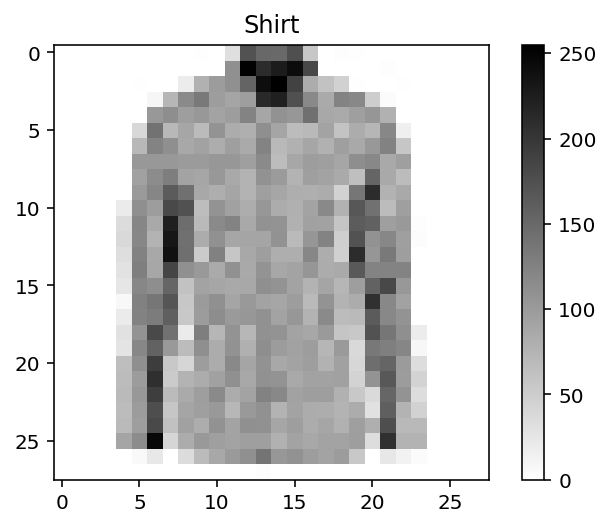

In [12]:
#take the first tuple of image and label
for image, label in training_set.take(1):
    #change the image tensor to array 
    # squeeze the dim (28,28,1) to (28,28)
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[label])
plt.colorbar()
plt.show()

## Create Pipeline

sperate the training, validation and testing data set into batches, and normalize the images by dividing its maximum.

In [13]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

# fist seperate the data set into batches and then apply the normalize function 
# to the whole batch to be more efficient
# shuffle 1/4 of the data set
training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

In [14]:
# None represent the batch size 64
training_batches

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

## Build and Train the Model

Here we'll build and compile our model as usual.

In [15]:
layer_neurons = [512, 256, 128]

dropout_rate = 0.5

model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation = 'relu'))
    #the dropout layer drop out a portion of the former layer
    model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 4

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/4
657/657 [==============================] - 52s 80ms/step - loss: 0.8400 - accuracy: 0.6934 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/4
657/657 [==============================] - 15s 23ms/step - loss: 0.5727 - accuracy: 0.7993 - val_loss: 0.4543 - val_accuracy: 0.8288
Epoch 3/4
657/657 [==============================] - 15s 23ms/step - loss: 0.5196 - accuracy: 0.8185 - val_loss: 0.4160 - val_accuracy: 0.8454
Epoch 4/4
657/657 [==============================] - 15s 22ms/step - loss: 0.4858 - accuracy: 0.8293 - val_loss: 0.3940 - val_accuracy: 0.8522


## Saving and Loading Models

In TensorFlow we can save our trained models in different formats. Here we will see how to save our models in TensorFlow's SavedModel format and as HDF5 files, which is the format used by Keras models.

### Saving and Loading Models in HDF5 Format

To save our models in the format used by Keras models we use the `.save(filepath)` method. For example, to save a model called `my_model` in the current working directory with the name `test_model` we use:

```python
my_model.save('./test_model.h5')
```

It's important to note that we have to provide the `.h5` extension to the `filepath` in order the tell `tf.keras` to save our model as an HDF5 file. 

The above command saves our model into a single HDF5 file that will contain:

* The model's architecture.
* The model's weight values which were learned during training.
* The model's training configuration, which corresponds to the parameters you passed to the `compile` method.
* The optimizer and its state. This allows you to resume training exactly where you left off.


In the cell below we save our trained `model` as an HDF5 file. The name of our HDF5 will correspond to the current time stamp. This is useful if you are saving many models and want each of them to have a unique name. By default the `.save()` method will **silently** overwrite any existing file at the target location with the same name. If we want `tf.keras` to provide us with a manual prompt to whether overwrite files with the same name, you can set the argument `overwrite=False` in the `.save()` method.

In [17]:
t = time.time()
t

1713001027.5375922

In [18]:
saved_keras_model_filepath = './{}.h5'.format(int(t))
saved_keras_model_filepath

'./1713001027.h5'

In [19]:
model.save(saved_keras_model_filepath)

Once a model has been saved, we can use `tf.keras.models.load_model(filepath)` to re-load our model. This command will also compile our model automatically using the saved training configuration, unless the model was never compiled in the first place.

In [20]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

As we can see the re-loaded model has the same architecture as our original model, as it should be. At this point, since we haven't done anything new to the re-loaded model, then both the `reloaded_keras_model` our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [21]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

0.0


In [22]:
print(type(prediction_1), prediction_1.shape)

<class 'numpy.ndarray'> (64, 10)


As we can see, the result is 0.0, which indicates that both models made the same predictions on the same images.

### Saving and Loading TensorFlow SavedModels

To export our models to the TensorFlow **SavedModel** format, we use the `tf.saved_model.save(model, export_dir)` function. For example, to save a model called `my_model` in a folder called `saved_models` located in the current working directory we use:

```python
tf.saved_model.save(my_model, './saved_models')
```

It's important to note that here we have to provide the path to the directory where we want to save our model, **NOT** the name of the file. This is because SavedModels are not saved in a single file. Rather, when you save your model as a SavedModel, `the tf.saved_model.save()` function will create an `assets` folder, a `variables` folder, and a `saved_model.pb` file inside the directory you provided.

The SavedModel files that are created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying TensorFlow graph. Separate graphs are saved for prediction (serving), training, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture configuration if available.

The SavedModel is a standalone serialization format for TensorFlow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. It does not require the original model building code to run, which makes it useful for sharing or deploying in different platforms, such as mobile and embedded devices (with TensorFlow Lite), servers (with TensorFlow Serving), and even web browsers (with TensorFlow.js).

In the cell below we save our trained model as a SavedModel. The name of the folder where we are going to save our model will correspond to the current time stamp. Again, this is useful if you are saving many models and want each of them to be saved in a unique directory.

In [23]:
t = time.time()

savedModel_directory = './{}'.format(int(t))

tf.saved_model.save(model, savedModel_directory)

Once a model has been saved as a SavedModel, we can use `tf.saved_model.load(export_dir)` to re-load our model. 

In [24]:
reloaded_SavedModel = tf.saved_model.load(savedModel_directory)

It's important to note that the object returned by `tf.saved_model.load` is **NOT** a Keras object. Therefore, it doesn't have `.fit`, `.predict`, `.summary`, etc. methods. It is 100% independent of the code that created it. This means that in order to make predictions with our `reloaded_SavedModel` we need to use a different method than the one used with the re-loaded Keras model.

To make predictions on a batch of images with a re-loaded SavedModel we have to use:

```python
reloaded_SavedModel(image_batch, training=False)
```

This will return a tensor with the predicted label probabilities for each image in the batch. Again, since we haven't done anything new to this re-loaded SavedModel, then both the `reloaded_SavedModel` and our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [25]:
#our original model is a keras object
model

In [26]:
#the reloaded model is not a keras object
reloaded_SavedModel

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fe835a57d10>

In [27]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_SavedModel(image_batch, training=False)
    prediction_2_numpy = reloaded_SavedModel(image_batch, training=False).numpy()
    difference = np.abs(prediction_1 - prediction_2_numpy)
    print(difference.max())

2.0861626e-07


In [28]:
print(type(prediction_2))

<class 'tensorflow.python.framework.ops.EagerTensor'>


We can also get back a full Keras model, from a TensorFlow SavedModel, by loading our SavedModel with the `tf.keras.models.load_model` function. 

In [29]:
reloaded_keras_model_from_SavedModel = tf.keras.models.load_model(savedModel_directory)

#this way we reload a keras object
reloaded_keras_model_from_SavedModel

## Saving Models During Training

We have seen that when we train a model with a validation set, the value of the validation loss changes through the training process. Since the value of the validation loss is an indicator of how well our model will generalize to new data, it will be great if could save our model at each step of the training process and then only keep the version with the lowest validation loss. 

We can do this in `tf.keras` by using the following callback:

```python
tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True)
```
This callback will save the model as a Keras HDF5 file after every epoch. With the `save_best_only=True` argument, this callback will first check the validation loss of the latest model against the one previously saved. The callback will only save the latest model and overwrite the old one, if the latest model has a lower validation loss than the one previously saved. This will guarantee that will end up with the version of the model that achieved the lowest validation loss during training.

In [30]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/100
657/657 [==============================] - 10s 15ms/step - loss: 0.5365 - accuracy: 0.8105 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
657/657 [==============================] - 7s 11ms/step - loss: 0.3924 - accuracy: 0.8589 - val_loss: 0.4010 - val_accuracy: 0.8531
Epoch 3/100
657/657 [==============================] - 7s 11ms/step - loss: 0.3469 - accuracy: 0.8722 - val_loss: 0.3963 - val_accuracy: 0.8531
Epoch 4/100
657/657 [==============================] - 7s 11ms/step - loss: 0.3170 - accuracy: 0.8823 - val_loss: 0.3403 - val_accuracy: 0.8751
Epoch 5/100
657/657 [==============================] - 7s 11ms/step - loss: 0.3013 - accuracy: 0.8897 - val_loss: 0.3566 - val_accuracy: 0.8685
Epoch 6/100
657/657 [==============================] - 7s 11ms/step - loss: 0.2879 - accuracy: 0.8922 - val_loss: 0.3381 - val_accuracy: 0.8794
Epoch 7/100
657/657 [==============================] - 7s 11ms/step - loss: 0.2722 - accuracy: 0.8982 - val_loss: 0.3266 - val_

## load back the model and make prediction

In [31]:
#load back the best model
best_model = tf.keras.models.load_model('./best_model.h5')

In [32]:
best_model

In [33]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


In [42]:
for image_batch, label_batch in testing_batches.take(1):
    # make prediction for the first image
    # since out model take dim (None, 28,28,1)
    # we need to reshape image_batch[0] from dim (28,28,1)
    # to (1,28,28,1)
    prediction = best_model.predict(tf.reshape(image_batch[0],(1,28,28,1)))
    #make prediction for the whole batch
    prediction_batch = best_model.predict(image_batch)
    #take the first image from the batch
    image = image_batch.numpy().squeeze()[0]
    

In [53]:
# the predicted probability of the first image
prediction_batch[0]

array([2.1902025e-03, 3.1883776e-06, 1.9023625e-02, 1.5191539e-04,
       9.3731892e-01, 9.5405213e-08, 2.3829622e-02, 7.9068099e-07,
       1.7481672e-02, 5.0179978e-08], dtype=float32)

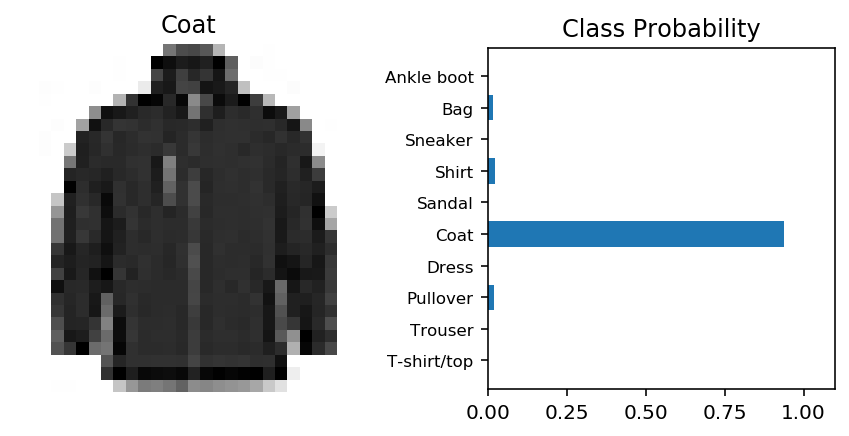

In [60]:
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(image, cmap = plt.cm.binary)
ax1.set_title(class_names[np.argmax(prediction_batch[0])])
ax1.axis('off')
ax2.barh(y = np.arange(len(prediction_batch[0])), width = prediction_batch[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(class_names, size='small')
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()